# Cats Vs Dogs
I'm going to use [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) to finetune a pre-existing model to differentiate between Cats and Dogs.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, datasets
import time
%matplotlib inline

In [2]:
torch.__version__

'2.0.0'

In [3]:
import sys
sys.version

'3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]'

**This file is intended to run on Google Colab**

Check if GPU is available, if not change the runtime

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Download the Data

The data from [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) consists of two files: images.tar.gz and annotations.tar.gz

In [5]:
%pwd

'/kaggle/working'

In [6]:
%mkdir data
%cd data

/kaggle/working/data


In [7]:
%%capture
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

Extract the downloaded files

In [8]:
%%capture
!tar zxvf images.tar.gz
!tar zxvf annotations.tar.gz

# Data Wrangling

In [9]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz


In [10]:
ls annotations

README  list.txt  test.txt  trainval.txt  trimaps/  xmls/


In [11]:
!head annotations/test.txt

Abyssinian_201 1 1 1
Abyssinian_202 1 1 1
Abyssinian_204 1 1 1
Abyssinian_205 1 1 1
Abyssinian_206 1 1 1
Abyssinian_207 1 1 1
Abyssinian_20 1 1 1
Abyssinian_210 1 1 1
Abyssinian_212 1 1 1
Abyssinian_213 1 1 1


In [12]:
!head annotations/trainval.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


In [13]:
%mkdir test train

In [14]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz  test/  train/


In [15]:

def check_dir(dir_path):
    dir_path = dir_path.replace('//','/')
    os.makedirs(dir_path, exist_ok=True)

In [16]:

import re
import os
import shutil
#Load Regex
pat = re.compile(r'_\d')
pwd = os.getcwd()
#define data wrangler function to format file system in desired order
def data_wrangle(folder, lowercase):
    #iterate through test file for list images to save to test dir
    with open(f'./annotations/{folder}.txt') as fp:
        line = fp.readline()
        while line:
            f,_,_,_ = line.split(' ')
            res,_ = pat.split(f)
            line = fp.readline()
            path = os.path.join(pwd,f"{folder}/",res)
            src = os.path.join(pwd,"images/",f"{f}.jpg")
            if not lowercase and not res.islower():
                check_dir(path)
                print("path '%s' created" %path)
                path = os.path.join(pwd,f"{folder}/{res}",f"{f}.jpg")
                shutil.copy(src, path)
                print(f"file from {src} copied to {path}")
            elif lowercase and res.islower():
                check_dir(path)
                print("path '%s' created" %path)
                path = os.path.join(pwd,f"{folder}/{res}",f"{f}.jpg")
                shutil.copy(src, path)
                print(f"file from {src} copied to {path}")

In [17]:
%%capture
data_wrangle("test",False);

In [18]:
%%capture
data_wrangle("test",True);

In [19]:
%%capture
data_wrangle("trainval",False);

In [20]:
%%capture
data_wrangle("trainval",True);

# DO NOT RUN ABOVE CODE AGAIN
#
#

In [21]:
%ls

annotations/        images/        test/   trainval/
annotations.tar.gz  images.tar.gz  train/


In [22]:
%ls trainval

Abyssinian/         american_pit_bull_terrier/  miniature_pinscher/
Bengal/             basset_hound/               newfoundland/
Birman/             beagle/                     pomeranian/
Bombay/             boxer/                      pug/
British_Shorthair/  chihuahua/                  saint_bernard/
Egyptian_Mau/       english_cocker_spaniel/     samoyed/
Maine_Coon/         english_setter/             scottish_terrier/
Persian/            german_shorthaired/         shiba_inu/
Ragdoll/            great_pyrenees/             staffordshire_bull_terrier/
Russian_Blue/       havanese/                   wheaten_terrier/
Siamese/            japanese_chin/              yorkshire_terrier/
Sphynx/             keeshond/
american_bulldog/   leonberger/


# Data Processing

In [23]:
%ls data
%cd data

ls: cannot access 'data': No such file or directory
[Errno 2] No such file or directory: 'data'
/kaggle/working/data


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, datasets
import time
import os
data_dir = os.getcwd()

All images need to be the same size to work with pytorch

In [25]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

vgg_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [26]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format)
        for x in ['trainval', 'test']}

In [27]:
os.path.join(data_dir, 'trainval')

'/kaggle/working/data/trainval'

In [28]:
dsets['trainval'].classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [29]:
dsets['trainval'].class_to_idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [30]:
dset_sizes = {x: len(dsets[x]) for x in ['trainval', 'test']}
dset_sizes

{'trainval': 3680, 'test': 3669}

In [31]:
dset_classes = dsets['trainval'].classes

In [32]:
loader_train = torch.utils.data.DataLoader(dsets['trainval'], batch_size = 8, shuffle = True, num_workers=2)

In [33]:
#?torch.utils.data.DataLoader

In [34]:
loader_valid = torch.utils.data.DataLoader(dsets['test'], batch_size = 8, shuffle = True, num_workers=2)

Check DataLoader

In [35]:
count = 1
for data in loader_valid:
    print(count, end=',')
    if count == 1:
        inputs_try,labels_try = data
    count += 1

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,

In [36]:
labels_try

tensor([ 3, 16, 20, 26, 28, 34, 30,  2])

In [37]:
inputs_try.shape

torch.Size([8, 3, 224, 224])

Defining function to display images:

In [38]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

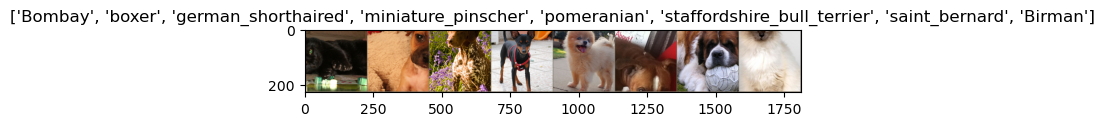

In [39]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

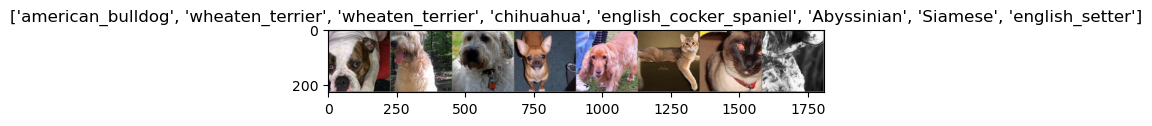

In [40]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))

n_images=8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [41]:
model_vgg = models.vgg16(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 110MB/s]


In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [43]:
outputs_try = model_vgg(inputs_try)

In [44]:
outputs_try

tensor([[-6.0287, -6.2795, -3.2400,  ..., -7.0425, -0.1228,  1.6110],
        [-4.2388, -2.2368, -3.0356,  ..., -0.1652, -0.1247,  3.5480],
        [-1.6192,  0.1231, -1.0613,  ...,  1.1603,  2.7300,  2.5721],
        ...,
        [-0.8658, -1.2606, -0.4931,  ..., -2.0389, -1.4559,  2.8900],
        [-7.2963, -7.9117, -3.5471,  ..., -2.6827, -0.8480,  7.2762],
        [-4.9917, -1.8948, -6.1488,  ..., -7.7938,  5.2167,  7.9858]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [45]:
outputs_try.shape

torch.Size([8, 1000])

In [46]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [47]:
for param in model_vgg.parameters():
    param.requires_grad = False
    model_vgg.classifier._modules['6'] = nn.Linear(4096,37)
    model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)    

In [48]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=37, bias=True)
  (7): LogSoftmax(dim=1)
)


Load Model onto device(GPU,CPU,TPU)

In [49]:
model_vgg = model_vgg.to(device)

# Training Fully Connected Models

## Creating loss function and optimizer

In [50]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

## Train the Model

In [51]:
def train_model(model,dataloader,size,epochs=1,optimizer=None):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [52]:
%%time
train_model(model_vgg,loader_train,size=dset_sizes['trainval'],epochs=2,optimizer=optimizer_vgg)

Loss: 0.2220 Acc: 0.6008
Loss: 0.0984 Acc: 0.8179
CPU times: user 44.7 s, sys: 1.83 s, total: 46.5 s
Wall time: 50.6 s


In [53]:
def test_model(model,dataloader,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,37))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    #print(size)
    for inputs,classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
            # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [54]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size=dset_sizes['test'])

Loss: 0.0769 Acc: 0.8771


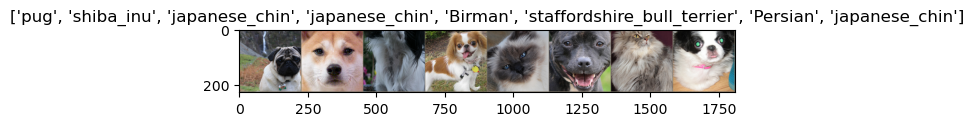

In [55]:
# Get a batch of training data
inputs, classes = next(iter(loader_valid))

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

Compute the predictions made by your network for inputs[:n_images] and the associated probabilities.

Hint: use torch.max and torch.exp.

Do not forget to put your inputs on the device!

In [56]:
outputs = model_vgg(inputs[:n_images].to(device))
print(torch.exp(outputs))

tensor([[4.0628e-04, 1.0412e-03, 1.0330e-03, 4.4166e-04, 1.6571e-03, 7.6335e-04,
         4.2610e-04, 1.9298e-03, 1.0289e-03, 4.5552e-04, 1.5223e-03, 1.4837e-03,
         5.2866e-03, 3.3537e-04, 3.7083e-04, 4.1212e-04, 1.5848e-02, 6.0226e-04,
         4.3368e-04, 1.9316e-04, 4.6577e-04, 5.7357e-04, 6.5669e-04, 3.7286e-03,
         6.4142e-04, 4.7239e-04, 3.8016e-04, 1.1363e-04, 1.5494e-04, 9.5251e-01,
         1.1116e-03, 3.8869e-04, 3.6962e-04, 6.0624e-04, 1.3039e-03, 6.0175e-04,
         2.4988e-04],
        [1.6001e-02, 5.0715e-03, 2.0780e-03, 9.4481e-04, 1.3199e-03, 1.6880e-03,
         2.4251e-03, 7.0359e-04, 4.1975e-03, 6.1315e-03, 5.3057e-03, 3.9383e-03,
         4.1665e-03, 3.1460e-03, 1.6902e-03, 8.0391e-02, 1.3443e-03, 6.6744e-02,
         1.0979e-03, 2.8520e-03, 9.5088e-04, 3.1677e-03, 1.3921e-03, 2.8590e-03,
         1.6337e-03, 8.7765e-04, 5.0645e-03, 9.5233e-04, 1.0505e-02, 1.4858e-03,
         1.1289e-03, 7.7140e-03, 2.2098e-03, 7.4042e-01, 5.0103e-03, 9.0585e-04,
      

In [57]:
vals_try, preds_try = torch.max(outputs,1)

In [58]:
preds_try

tensor([29, 33, 23, 23,  2, 34,  7, 23], device='cuda:0')

In [59]:
classes[:n_images]

tensor([29, 33, 23, 23,  2, 34,  7, 23])

In [60]:
torch.exp(vals_try)

tensor([0.9525, 0.7404, 0.4035, 0.9769, 0.7152, 0.9425, 0.9382, 0.9190],
       device='cuda:0', grad_fn=<ExpBackward0>)

# Speeding up the learning process by precomputing features

In [61]:
def preconvfeat(dataloader):
    conv_features = []
    labels_list = []
    for data in dataloader:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [62]:
%%time
conv_feat_train,labels_train = preconvfeat(loader_train)

CPU times: user 23 s, sys: 1.75 s, total: 24.7 s
Wall time: 26.2 s


In [63]:
conv_feat_train.shape

(3680, 512, 7, 7)

In [64]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

CPU times: user 23.7 s, sys: 1.83 s, total: 25.6 s
Wall time: 26.5 s


# Creating a new data generator
we will not load images anymore, so we need to build our own data loader.

In [65]:
dtype=torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)

now you can train for more epochs.

In [66]:
%%time
train_model(model_vgg.classifier,dataloader=loaderfeat_train,size=dset_sizes['trainval'],epochs=80,optimizer=optimizer_vgg)

Loss: 0.0050 Acc: 0.8573
Loss: 0.0049 Acc: 0.8652
Loss: 0.0048 Acc: 0.8611
Loss: 0.0047 Acc: 0.8663
Loss: 0.0047 Acc: 0.8658
Loss: 0.0046 Acc: 0.8622
Loss: 0.0046 Acc: 0.8671
Loss: 0.0045 Acc: 0.8709
Loss: 0.0044 Acc: 0.8731
Loss: 0.0044 Acc: 0.8698
Loss: 0.0043 Acc: 0.8704
Loss: 0.0043 Acc: 0.8734
Loss: 0.0043 Acc: 0.8747
Loss: 0.0043 Acc: 0.8734
Loss: 0.0041 Acc: 0.8785
Loss: 0.0041 Acc: 0.8755
Loss: 0.0041 Acc: 0.8709
Loss: 0.0040 Acc: 0.8774
Loss: 0.0040 Acc: 0.8755
Loss: 0.0039 Acc: 0.8872
Loss: 0.0039 Acc: 0.8840
Loss: 0.0039 Acc: 0.8726
Loss: 0.0039 Acc: 0.8769
Loss: 0.0038 Acc: 0.8810
Loss: 0.0037 Acc: 0.8870
Loss: 0.0037 Acc: 0.8840
Loss: 0.0038 Acc: 0.8829
Loss: 0.0037 Acc: 0.8870
Loss: 0.0037 Acc: 0.8742
Loss: 0.0037 Acc: 0.8845
Loss: 0.0036 Acc: 0.8902
Loss: 0.0037 Acc: 0.8856
Loss: 0.0036 Acc: 0.8851
Loss: 0.0036 Acc: 0.8834
Loss: 0.0036 Acc: 0.8864
Loss: 0.0035 Acc: 0.8889
Loss: 0.0035 Acc: 0.8913
Loss: 0.0035 Acc: 0.8929
Loss: 0.0034 Acc: 0.8894
Loss: 0.0035 Acc: 0.8837


In [67]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

Now you can compute the accuracy on the test set.

In [68]:
predictions, all_proba, all_classes = test_model(model_vgg.classifier,dataloader=loaderfeat_valid,size=dset_sizes['test'])

Loss: 0.0033 Acc: 0.8842


# Confusion matrix
For 37 classes, plotting a confusion matrix is useful to see the performance of the algorithm per class.

In [69]:
!pip3 install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 72.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [70]:
from sklearn.metrics import confusion_matrix
import itertools
def make_fig_cm(cm):
    fig = plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_marks = np.arange(37);
    plt.xticks(tick_marks, dset_classes, rotation=90);
    plt.yticks(tick_marks, dset_classes, rotation=0);
    plt.tight_layout();
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual');
    plt.xlabel('Predicted');

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [71]:
cm = confusion_matrix(all_classes,predictions)


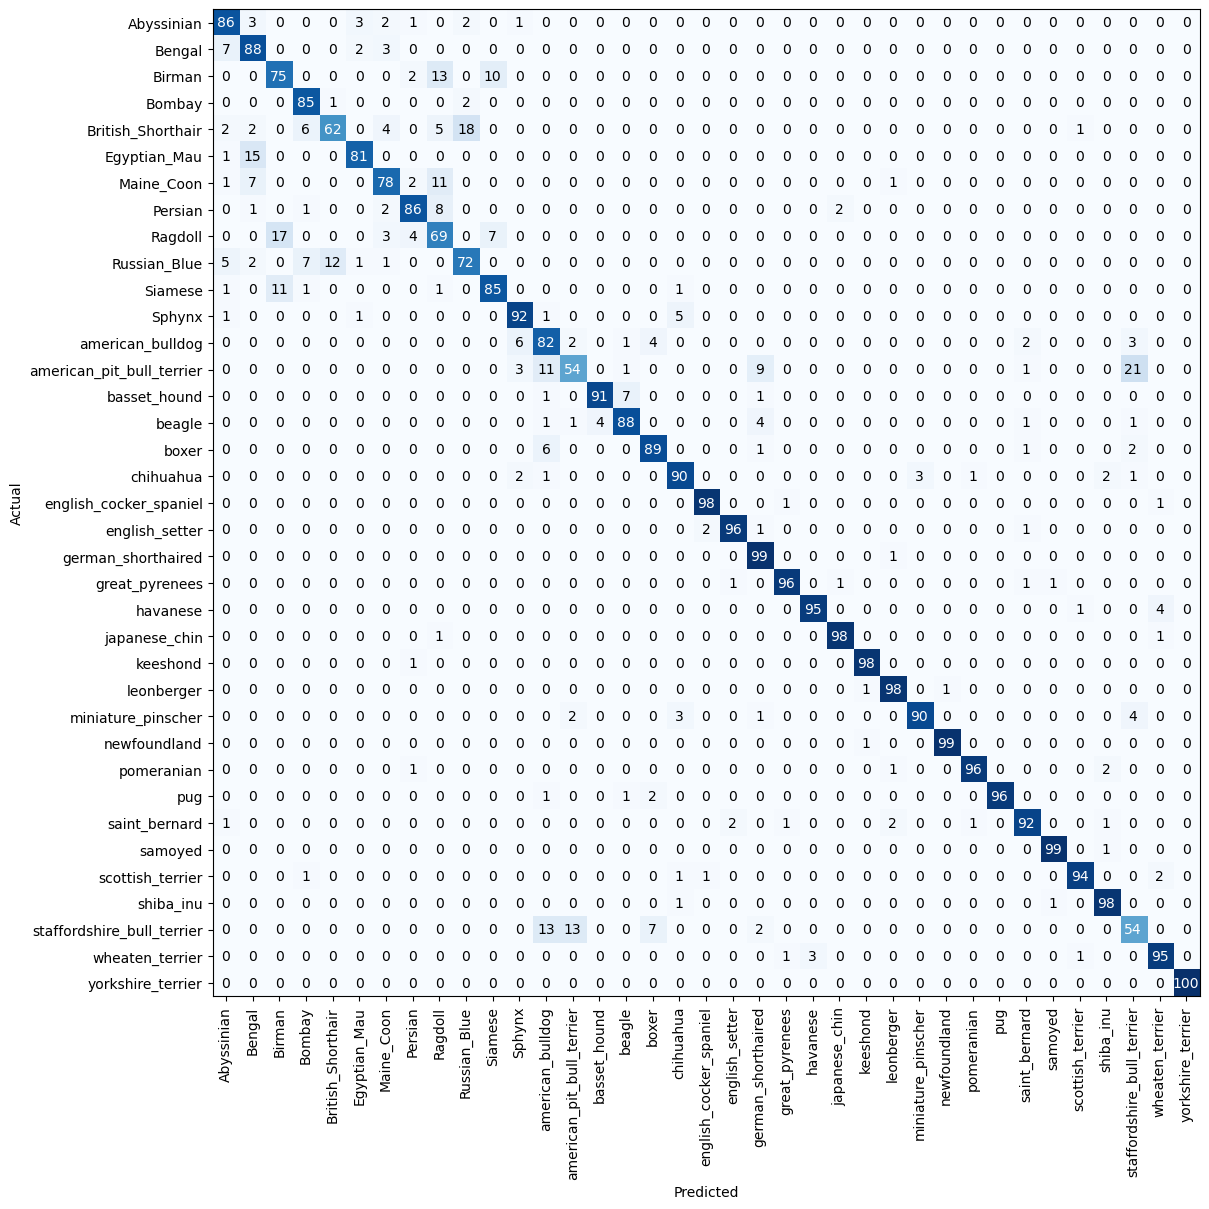

In [72]:
make_fig_cm(cm)

Here, you see that american pit bull terrier are often predicted as staffordshire bull terrier but overall the algorithm gives pretty good results!

Now, I will take a resnet34 model to modify it

In [73]:
import torchvision
import torch.nn as nn
from torchvision import models,transforms,datasets
model_resnet = torchvision.models.resnet34(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 236MB/s]


In [74]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [75]:
print(model_resnet.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [76]:
model_resnet.eval()
for param in model_resnet.parameters():
    param.requires_grad = False
# your code here
model_resnet.fc = nn.Linear(512, 37)


replace the last layer to 1000 inputs and 37 outputs

In [77]:
#import torch
#model_resnet.fc = nn.Linear(1000,37)

In [78]:
print(model_resnet.fc)

Linear(in_features=512, out_features=37, bias=True)


Create a soft max layer

In [79]:
model_resnet_lsm = nn.Sequential(model_resnet, torch.nn.LogSoftmax(dim = 1))
#model_resnet_lsm = nn.Sequential(models.resnet34(weights='DEFAULT'), nn.LogSoftmax(dim=1))

check everything is working

In [80]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)
model_resnet_lsm = model_resnet_lsm.to(device)
outputs_try = model_resnet_lsm(inputs_try)

In [81]:
outputs_try.shape

torch.Size([8, 37])

In [82]:
print(model_resnet_lsm[0].fc)

Linear(in_features=512, out_features=37, bias=True)


In [83]:
lr = 0.001
optimizer_resnet = torch.optim.SGD(model_resnet_lsm[0].fc.parameters(),lr = lr)

In [84]:
%%time
train_model(model_resnet_lsm,loader_train,size=dset_sizes['trainval'],epochs=30,optimizer=optimizer_resnet)

Loss: 0.4161 Acc: 0.1587
Loss: 0.3299 Acc: 0.4617
Loss: 0.2687 Acc: 0.6228
Loss: 0.2265 Acc: 0.7035
Loss: 0.1987 Acc: 0.7342
Loss: 0.1740 Acc: 0.7587
Loss: 0.1578 Acc: 0.7791
Loss: 0.1463 Acc: 0.7957
Loss: 0.1344 Acc: 0.8024
Loss: 0.1258 Acc: 0.8130
Loss: 0.1178 Acc: 0.8163
Loss: 0.1125 Acc: 0.8193
Loss: 0.1090 Acc: 0.8198
Loss: 0.1051 Acc: 0.8236
Loss: 0.1021 Acc: 0.8291
Loss: 0.0979 Acc: 0.8342
Loss: 0.0958 Acc: 0.8323
Loss: 0.0964 Acc: 0.8196
Loss: 0.0931 Acc: 0.8337
Loss: 0.0880 Acc: 0.8435
Loss: 0.0874 Acc: 0.8484
Loss: 0.0848 Acc: 0.8508
Loss: 0.0823 Acc: 0.8476
Loss: 0.0824 Acc: 0.8519
Loss: 0.0815 Acc: 0.8481
Loss: 0.0803 Acc: 0.8484
Loss: 0.0793 Acc: 0.8457
Loss: 0.0777 Acc: 0.8533
Loss: 0.0739 Acc: 0.8535
Loss: 0.0748 Acc: 0.8503
CPU times: user 3min 29s, sys: 30.2 s, total: 3min 59s
Wall time: 7min 15s


In [85]:
model_resnet_lsm.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [86]:
%%time
predictions, all_proba, all_classes = test_model(model_resnet_lsm,loader_valid,size=dset_sizes['test'])

Loss: 0.0626 Acc: 0.8637
CPU times: user 6.41 s, sys: 895 ms, total: 7.3 s
Wall time: 14.1 s


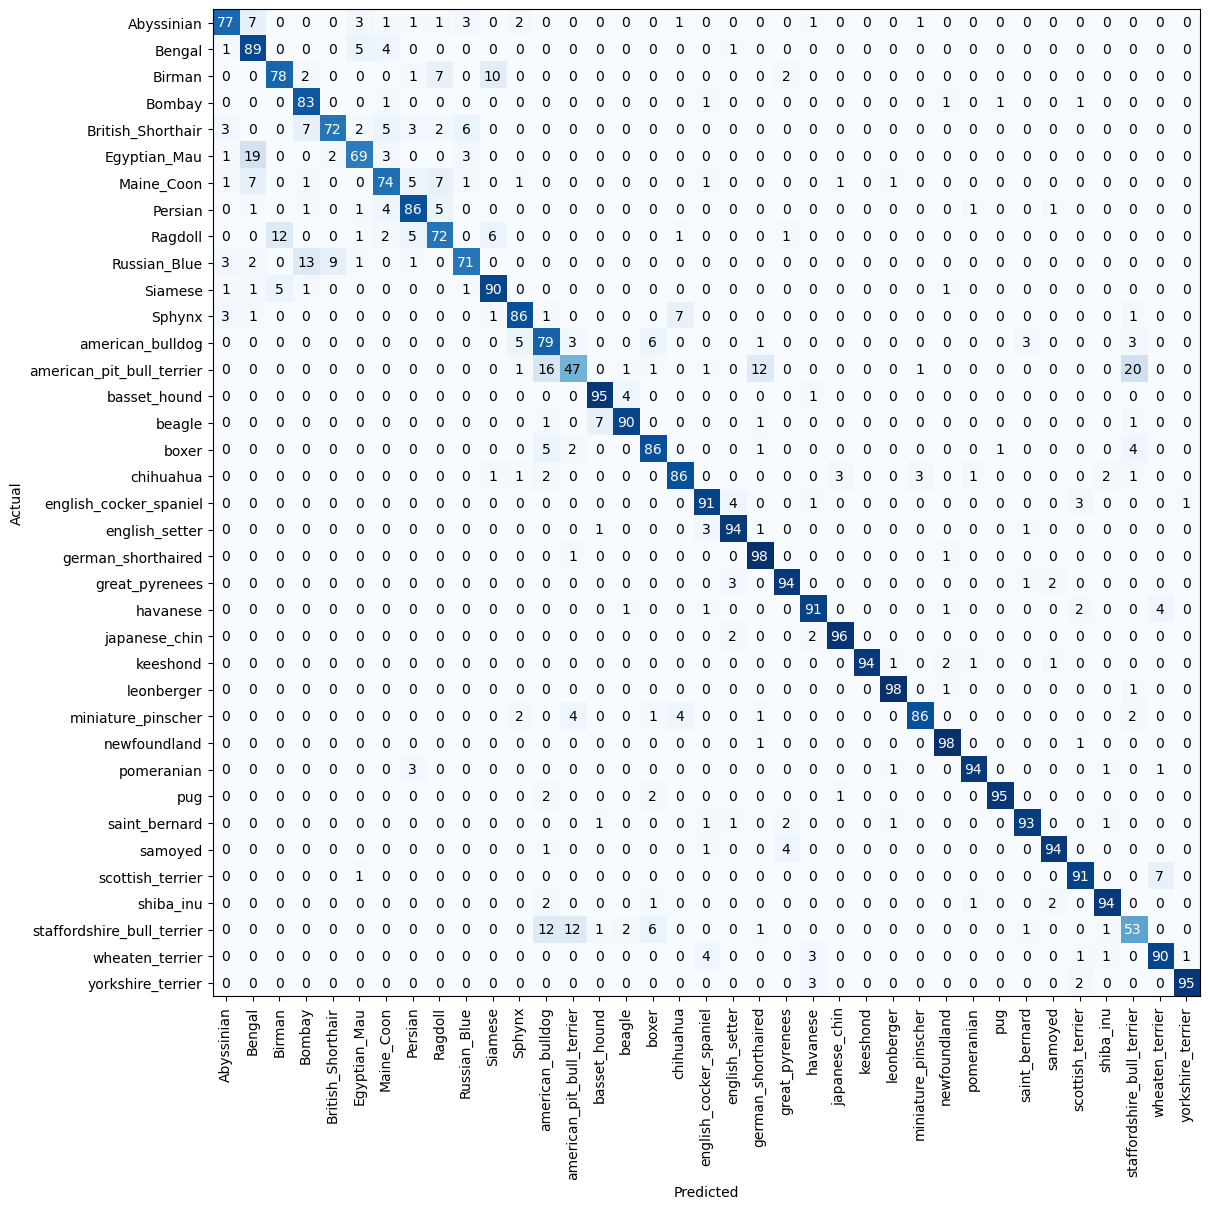

In [87]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)